# Hello

In [96]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output

## Load Data

In [97]:
#load .npz-file from folder
data_folder = "data/"
loader = np.load(data_folder+"gray_image_data_xs.npz")
train_data = loader["train_features"]
train_labels = loader["train_labels"]
val_data = loader["val_features"]
val_labels = loader["val_labels"]

# one-hot encoding
en = OneHotEncoder(handle_unknown="ignore")
train_labels = en.fit_transform(train_labels.reshape((-1,1))).toarray()
val_labels = en.transform(val_labels.reshape((-1,1))).toarray()

train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)

In [98]:
train_data.shape

(800, 1, 100, 100)

In [99]:
train_labels.shape

(800, 448)

In [100]:
# preprocess (already done hopefully)

## Build Model

In [101]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
        

    

class CNN:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, name,learning_rate=0.001, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.name = name
        self.learning_rate = learning_rate
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
        
        
    def make_plot(self):
        train_acc_dropoutreg = self.hist['train_accuracy'][-1]
        val_acc_dropoutreg = self.hist['val_accuracy'][-1]

        print("dr:",f"{train_acc_dropoutreg:.3f}",f"{val_acc_dropoutreg:.3f}")

        print(epochs, batch_size, learning_rate)
        print("maxacc,minloss at epoch: ", np.argmax(self.hist['val_accuracy']),np.argmin(self.hist['val_loss']),\
              "acc there: ", self.hist['val_accuracy'][np.argmax(self.hist['val_accuracy'])],\
             self.hist['val_accuracy'][np.argmin(self.hist['val_loss'])])

        plt.figure(figsize=(10,5))

        plt.plot(self.hist['train_loss'][5::], 
                 label="Training (dropout regularization)")
        plt.plot(self.hist['val_loss'][5::], 
                 label="Validation (dropout regularization)", linestyle="--")
        
        plt.xlabel("Epoch", fontsize=20)
        plt.ylabel("Loss", fontsize=20)
        plt.legend()
        plt.show()
    
    def build(self, length, height, num_classes, channels=1):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, channels, length, height], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name):
        
            hidden = self.X
            
            # 1,100*100 -> 16,50*50
            conv1 = tf.layers.conv2d(inputs=hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            max_pool_1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2, padding='same')

            # 16,100*100 -> 32,25*25
            conv2 = tf.layers.conv2d(inputs=max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            max_pool_2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2, padding='same')
            
            hidden = tf.reshape(max_pool_2, (-1, 32*25))
            hidden = tf.nn.dropout(hidden, 1-self.dropout)

            # Predictions
            #hidden = tf.layers.dense(hidden, 128)
            #hidden = tf.nn.dropout(hidden, 1-self.dropout)
            self.logits = tf.layers.dense(hidden, num_classes)
            
            

            self.cross_entropy_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits,labels=self.Y,name="cross_entropy_loss"))
            
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.logits > 0, tf.cast(self.Y, tf.bool)),tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, session, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        self.dropout = dropout
        

        self.session = session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                        
            for epoch in range(epochs):
                if (epoch + 1) % 10 == 0:
                    #clear_output()
                    print(f"Epoch {epoch+1}/{epochs}")
                    self.make_plot()
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run( self.optimizer, feed_dict={self.X: train_data[batch_ixs], self.Y: train_labels[batch_ixs]})
                    
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)    

                
                self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}
                

In [102]:
# hyperparams
epochs = 50
batch_size = 64
learning_rate = 0.001

width, height = 100,100

Epoch 10/50
dr: 0.998 0.998
50 64 0.001
maxacc,minloss at epoch:  1 9 acc there:  0.998125 0.99776787


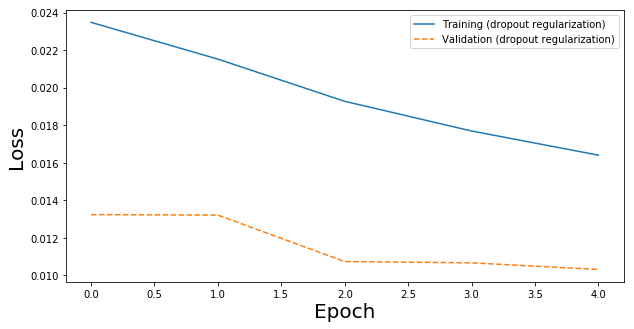

Epoch 20/50
dr: 0.998 0.998
50 64 0.001
maxacc,minloss at epoch:  17 17 acc there:  0.99815845 0.99815845


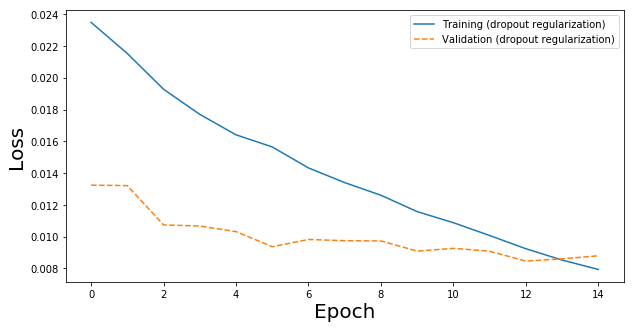

Epoch 30/50
dr: 0.999 0.998
50 64 0.001
maxacc,minloss at epoch:  28 20 acc there:  0.99834824 0.99825895


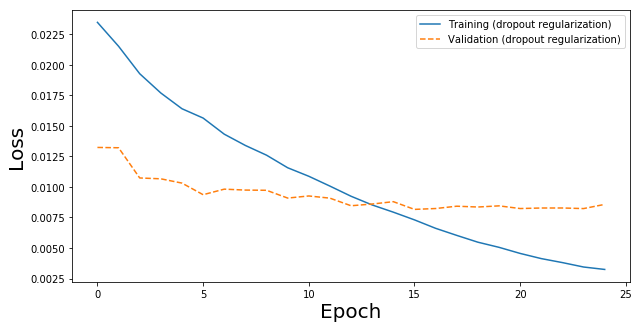

Epoch 40/50
dr: 0.999 0.998
50 64 0.001
maxacc,minloss at epoch:  28 20 acc there:  0.99834824 0.99825895


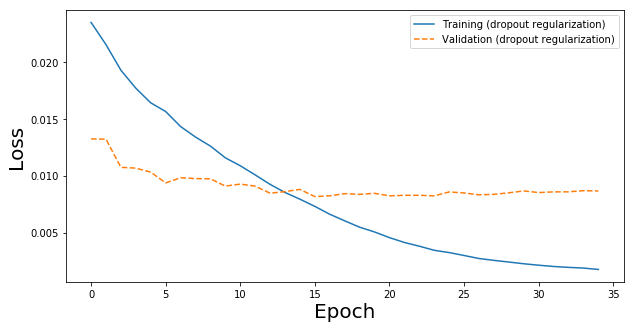

Epoch 50/50
dr: 0.999 0.998
50 64 0.001
maxacc,minloss at epoch:  28 20 acc there:  0.99834824 0.99825895


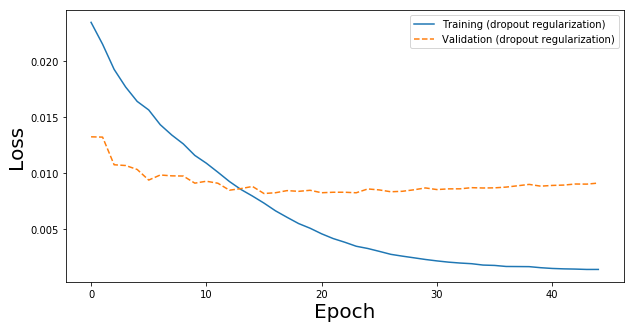

In [103]:
# train model
tf.reset_default_graph()
with tf.Session() as session:
    cnn = CNN("dropout_regularization", learning_rate=learning_rate)
    cnn.build(width, height, num_classes=train_labels.shape[1])
    cnn.train(session, train_data, train_labels, val_data, val_labels, epochs, batch_size=batch_size, dropout=0.5)
    #test_preds_cnn = cnn.logits.eval({cnn.X: test_data}, session=session).argmax(1)

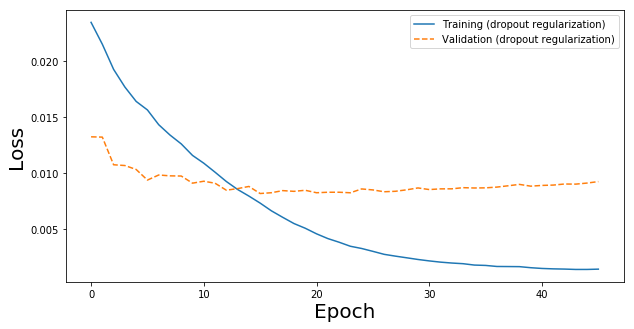

In [104]:
# evaluate model
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_loss'][5::], 
         label="Training (dropout regularization)")
plt.plot(cnn.hist['val_loss'][5::], 
         label="Validation (dropout regularization)", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

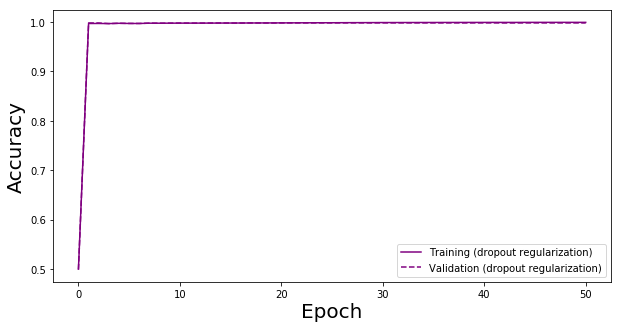

In [105]:
# Accuracy Plot
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_accuracy'], 
         label="Training (dropout regularization)", color="purple")
plt.plot(cnn.hist['val_accuracy'], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()